In [1]:
%load_ext autoreload
%autoreload 2

# Multislice Simulations (ED and CBED)

The multislice algorithm works by incrementally stepping the 2d lateral part of the wave function forward along the optical axis. A step forward through a slice of the potential consists of a transmission and a propagation. The `Wave` objects can be transmitted through a potential slice, which in the weak-phase approximation is just a phase shift. To complete a forward step the transmitted wave is propagated by the thickness of the slice using in the fresnel approximation.

We import the potential from the previous tutorial and set up a plane wave with an energy of 300 keV.

In [1]:
from abtem.potentials import ArrayPotential
from abtem.waves import PlaneWave

potential = ArrayPotential.read('srtio3_110_potential.hdf5')

wave = PlaneWave(energy=300e3)

To propagate the wave function through the potential we use the `.multislice` method.

In [18]:
from abtem.potentials import Potential

exit_wave = PlaneWave(energy=300e3).multislice(potential)

exit_wave.write('srtio3_exit_wave.hdf5')

We show the intensity of the resulting exit wave.

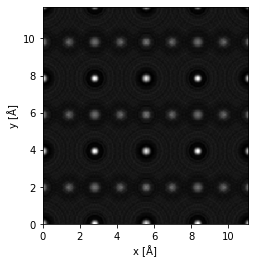

In [19]:
exit_wave.show()

The electron diffraction pattern can be obtained using the `.diffraction_pattern` method.

In [4]:
diffraction_pattern = exit_wave.diffraction_pattern()

A diffraction pattern typically has a very large dynamic range in its intensity. Hence, we display it on a logarithmic scale.

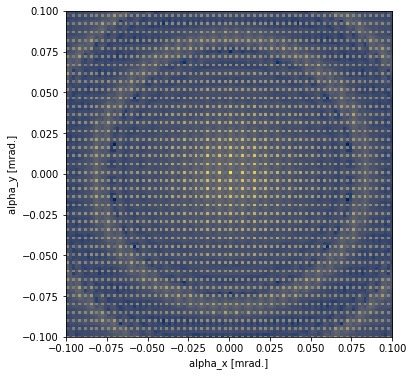

In [20]:
diffraction_pattern = exit_wave.diffraction_pattern()

ax, im = diffraction_pattern.show(log_scale=True, figsize=(6,6), cmap='cividis')

ax.set_xlim([-.1,.1])
ax.set_ylim([-.1,.1]);

<div class= "alert alert-info">

**Note:**

You may have noted that the grid of the wave function was not given above. Using the multislice function, the wave function just adopts the grid of the potential before starting the multislice propagation. On the other hand, the following will result in a runtime error because the sampling cannot be inferred from the information given.

```python
wave = PlaneWave(energy=300e3)
potential = Potential(atoms)
exit_wave = wave.multislice(potential)
```

The next bit of code will also result in an error because the sampling of the wave function and the potential is different.

```python
wave = PlaneWaves(sampling=.1, energy=300e3)
potential = Potential(atoms, sampling=.05)
exit_wave = wave.multislice(potential)
```
    
</div>

## Multislice simulation with probe

Imaging modes utilizing an electron probe requires us to provide a position for the probe.

In [21]:
from abtem.waves import Probe

probe = Probe(energy=200e3, semiangle_cutoff=.02, rolloff=.1)

exit_wave = probe.multislice((5,6), potential)

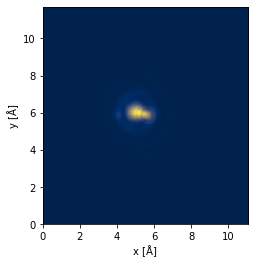

In [22]:
exit_wave.show(cmap='cividis')

The convergent beam electron diffraction (CBED) pattern, can be calculated in the same manner as the ED pattern. We display the result on a log scale.

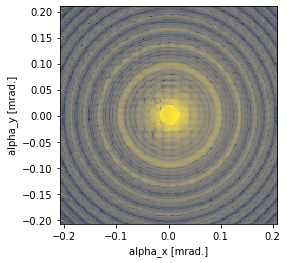

In [23]:
diffraction_pattern = exit_wave.diffraction_pattern()

ax, im = diffraction_pattern.show(log_scale=True, cmap='cividis')

## The multislice algorithm using low-level interface

If additional control is necessary, it is possible to run the multislice algorithm using a lower level interface. We start by building the plane wave wavefunction. We ensure that the wave function matches the potential by using `.match` method of the wave function grid.

In [26]:
wave = PlaneWave(energy=300e3)

wave.grid.match(potential)

wave = wave.build()

Below we complete one full step of the multislice algorithm, by transmitting and then propagating the wave function. This requires importing the `FresnelPropagator` class and the `transmit` function. 

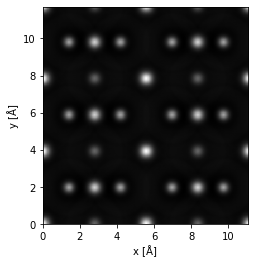

In [27]:
from abtem.waves import FresnelPropagator, transmit

potential_slice = potential[7]
propagator = FresnelPropagator()

wave = transmit(wave, potential_slice)

wave = propagator.propagate(wave, potential_slice.thickness)

wave.show()

The complete multislice algorithm just repeats this for all slices sequentially, hence it can be implemented as the following loop.

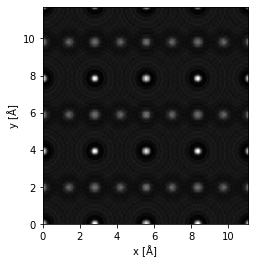

In [19]:
for potential_slice in potential:
    wave = transmit(wave, potential_slice)
    wave = propagator.propagate(wave, potential_slice.thickness)

wave.show();